<a href="https://colab.research.google.com/github/PratikhyaManas/Predict-Crime-Rate-in-Chicago/blob/master/Predict_Crime_Rate_in_Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP #0: PROBLEM STATEMENT

- Image Source: https://commons.wikimedia.org/wiki/File:Chicago_skyline,_viewed_from_John_Hancock_Center.jpg
- The Chicago Crime dataset contains a summary of the reported crimes occurred in the City of Chicago from 2001 to 2017. 
- Dataset has been obtained from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system.
- Dataset contains the following columns: 
    - ID: Unique identifier for the record.
    - Case Number: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
    - Date: Date when the incident occurred.
    - Block: address where the incident occurred
    - IUCR: The Illinois Unifrom Crime Reporting code.
    - Primary Type: The primary description of the IUCR code.
    - Description: The secondary description of the IUCR code, a subcategory of the primary description.
    - Location Description: Description of the location where the incident occurred.
    - Arrest: Indicates whether an arrest was made.
    - Domestic: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
    - Beat: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. 
    - District: Indicates the police district where the incident occurred. 
    - Ward: The ward (City Council district) where the incident occurred. 
    - Community Area: Indicates the community area where the incident occurred. Chicago has 77 community areas. 
    - FBI Code: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 
    - X Coordinate: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Y Coordinate: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
    - Year: Year the incident occurred.
    - Updated On: Date and time the record was last updated.
    - Latitude: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Longitude: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Location: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.
- Datasource: https://www.kaggle.com/currie32/crimes-in-chicago

# STEP #1: IMPORTING DATA

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet


# The below Code Snippet is used to set connection between Google drive and Google Colab to load multiple files (Optional)

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive


!ls My Drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > My Drive/created.txt

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [3]:
# dataframes creation for both training and testing datasets 
chicago_df_1 = pd.read_csv('Drive/Project 3/Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
chicago_df_2 = pd.read_csv('Drive/Project 3/Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
chicago_df_3 = pd.read_csv('Drive/Project 3/Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)


b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [0]:

chicago_df = pd.concat([chicago_df_1, chicago_df_2, chicago_df_3], ignore_index=False, axis=0)


# STEP #2: EXPLORING THE DATASET  

In [5]:
# Let's view the head of the training dataset
chicago_df.head()

Unnamed: 0       ID  ...  Longitude                       Location
0           0  4673626  ... -87.771996  (41.981912692, -87.771996382)
1           1  4673627  ... -87.611920  (41.775732538, -87.611919814)
2           2  4673628  ... -87.593671  (41.769897392, -87.593670899)
3           4  4673629  ... -87.780057  (41.942984005, -87.780056951)
4           5  4673630  ... -87.716745   (41.784210853, -87.71674491)

[5 rows x 23 columns]

In [6]:
# Let's view the last elements in the training dataset
chicago_df.tail(20)

Unnamed: 0        ID  ...  Longitude                       Location
1456694     6246478  10508650  ... -87.664670  (41.751166357, -87.664670209)
1456695     6246521  10508653  ... -87.693623  (41.908426978, -87.693622615)
1456696     6247563  10508656  ... -87.646092   (41.907378476, -87.64609233)
1456697     6247798  10508658  ... -87.705387  (41.856510401, -87.705387422)
1456698     6248016  10508659  ... -87.633775     (41.82417802, -87.6337748)
1456699     6248192  10508661  ... -87.623332  (41.766796861, -87.623332025)
1456700     6248278  10508662  ... -87.622359  (41.790520722, -87.622358898)
1456701     6248713  10508663  ... -87.706062  (41.771625308, -87.706062047)
1456702     6248779  10508664  ... -87.649876  (41.742462184, -87.649876395)
1456703     6248999  10508665  ... -87.657669  (41.720164061, -87.657669427)
1456704     6249417  10508666  ... -87.723251   (41.79639731, -87.723251281)
1456705     6249592  10508671  ... -87.534736  (41.702731182, -87.534736413)
1456706     6249615  10508672  ... -87.694225   (41.763522012, -87.69422464)
1456707     6249936  10508675  ... -87.652203  (41.738710803, -87.652202523)
1456708     6250154  10508678  ... -87.660561  (41.733329054, -87.660561367)
1456709     6250330  10508679  ... -87.691556   (41.849222028, -87.69155551)
1456710     6251089  10508680  ... -87.633335   (41.760743949, -87.63333531)
1456711     6251349  10508681  ... -87.685207  (41.779234743, -87.685207125)
1456712     6253257  10508690  ... -87.552773  (41.745251975, -87.552773464)
1456713     6253474  10508692  ... -87.620658   (41.75830866, -87.620658418)

[20 rows x 23 columns]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


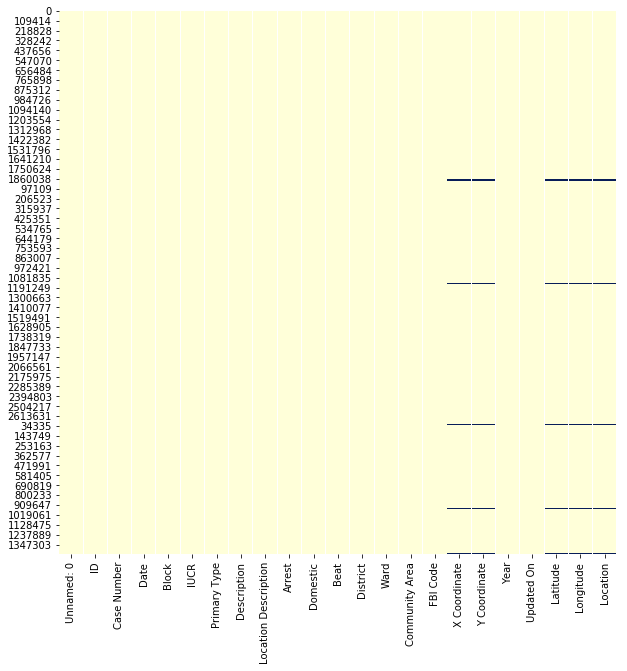

In [7]:
# Let's see how many null elements are contained in the data
plt.figure(figsize=(10,10))
sns.heatmap(chicago_df.isnull(), cbar = False, cmap = 'YlGnBu')

In [0]:
# ID Case Number Date Block IUCR Primary Type Description Location Description Arrest Domestic Beat District Ward Community Area FBI Code X Coordinate Y Coordinate Year Updated On Latitude Longitude Location
chicago_df.drop(['Unnamed: 0', 'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'], inplace=True, axis=1)

In [9]:
chicago_df

ID                    Date  ... Arrest Domestic
0         4673626  04/02/2006 01:00:00 PM  ...  False    False
1         4673627  02/26/2006 01:40:48 PM  ...   True    False
2         4673628  01/08/2006 11:16:00 PM  ...  False    False
3         4673629  04/05/2006 06:45:00 PM  ...  False    False
4         4673630  02/17/2006 09:03:14 PM  ...   True    False
5         4673631  03/30/2006 10:30:00 PM  ...   True    False
6         4673632  04/05/2006 12:10:00 PM  ...   True    False
7         4673633  04/05/2006 03:00:00 PM  ...  False    False
8         4673634  04/05/2006 09:30:00 PM  ...  False    False
9         4673635  04/03/2006 03:00:00 AM  ...  False     True
10        4673637  04/06/2006 11:15:00 AM  ...  False    False
11        4673639  04/04/2006 08:15:00 PM  ...   True    False
12        4673640  04/06/2006 11:30:00 AM  ...  False    False
13        4673642  02/26/2006 02:47:21 PM  ...   True    False
14        4673643  04/03/2006 08:09:00 PM  ...  False    False
15        4673644  02/17/2006 09:26:33 PM  ...   True    False
16        4673645  04/05/2006 08:00:00 AM  ...  False    False
17        4673646  03/31/2006 08:20:00 AM  ...  False     True
18        4673648  04/05/2006 01:30:00 PM  ...   True    False
19        4673649  03/31/2006 05:00:00 AM  ...  False    False
20        4674087  03/28/2006 10:00:00 PM  ...  False    False
21        4673651  02/17/2006 09:49:21 PM  ...   True    False
22        4673652  04/05/2006 06:18:00 PM  ...  False    False
23        4673653  04/06/2006 09:45:00 AM  ...  False    False
24        4673654  03/31/2006 09:13:54 AM  ...   True     True
25        4673655  04/05/2006 10:30:00 PM  ...  False    False
26        4673656  04/05/2006 10:10:00 PM  ...  False    False
27        4673657  03/31/2006 10:00:00 AM  ...   True    False
28        4673658  02/17/2006 10:07:09 PM  ...   True    False
29        4673659  04/05/2006 05:00:00 PM  ...  False    False
...           ...                     ...  ...    ...      ...
1456684  10508639  05/03/2016 10:32:00 PM  ...  False    False
1456685  10508640  05/03/2016 10:07:00 PM  ...   True    False
1456686  10508641  05/03/2016 10:31:00 PM  ...  False    False
1456687  10508642  05/03/2016 10:45:00 PM  ...  False     True
1456688  10508643  05/03/2016 09:00:00 PM  ...  False     True
1456689  10508644  05/03/2016 07:13:00 PM  ...  False    False
1456690  10508646  05/03/2016 07:45:00 PM  ...  False    False
1456691  10508647  05/03/2016 08:56:00 PM  ...  False    False
1456692  10508648  05/03/2016 10:10:00 PM  ...   True     True
1456693  10508649  05/03/2016 10:15:00 PM  ...  False    False
1456694  10508650  05/03/2016 05:00:00 PM  ...  False    False
1456695  10508653  05/03/2016 11:58:00 PM  ...   True    False
1456696  10508656  05/03/2016 03:15:00 PM  ...  False     True
1456697  10508658  05/03/2016 11:50:00 PM  ...   True    False
1456698  10508659  05/03/2016 11:38:00 PM  ...  False    False
1456699  10508661  05/03/2016 08:44:00 PM  ...  False    False
1456700  10508662  05/03/2016 08:00:00 AM  ...  False    False
1456701  10508663  05/03/2016 10:10:00 PM  ...  False    False
1456702  10508664  05/03/2016 11:35:00 PM  ...   True     True
1456703  10508665  05/03/2016 10:15:00 PM  ...  False     True
1456704  10508666  05/03/2016 11:30:00 PM  ...  False    False
1456705  10508671  05/03/2016 11:50:00 PM  ...   True    False
1456706  10508672  05/03/2016 10:25:00 PM  ...   True    False
1456707  10508675  05/03/2016 11:00:00 PM  ...  False    False
1456708  10508678  05/03/2016 11:28:00 PM  ...  False    False
1456709  10508679  05/03/2016 11:33:00 PM  ...   True     True
1456710  10508680  05/03/2016 11:30:00 PM  ...   True     True
1456711  10508681  05/03/2016 12:15:00 AM  ...  False    False
1456712  10508690  05/03/2016 09:07:00 PM  ...  False     True
1456713  10508692  05/03/2016 11:38:00 PM  ...   True    False

[6017767 rows x 8 columns]

In [0]:
# Assembling a datetime by rearranging the dataframe column "Date". 

chicago_df.Date = pd.to_datetime(chicago_df.Date, format='%m/%d/%Y %I:%M:%S %p')


In [11]:
chicago_df

ID                Date  ... Arrest Domestic
0         4673626 2006-04-02 13:00:00  ...  False    False
1         4673627 2006-02-26 13:40:48  ...   True    False
2         4673628 2006-01-08 23:16:00  ...  False    False
3         4673629 2006-04-05 18:45:00  ...  False    False
4         4673630 2006-02-17 21:03:14  ...   True    False
5         4673631 2006-03-30 22:30:00  ...   True    False
6         4673632 2006-04-05 12:10:00  ...   True    False
7         4673633 2006-04-05 15:00:00  ...  False    False
8         4673634 2006-04-05 21:30:00  ...  False    False
9         4673635 2006-04-03 03:00:00  ...  False     True
10        4673637 2006-04-06 11:15:00  ...  False    False
11        4673639 2006-04-04 20:15:00  ...   True    False
12        4673640 2006-04-06 11:30:00  ...  False    False
13        4673642 2006-02-26 14:47:21  ...   True    False
14        4673643 2006-04-03 20:09:00  ...  False    False
15        4673644 2006-02-17 21:26:33  ...   True    False
16        4673645 2006-04-05 08:00:00  ...  False    False
17        4673646 2006-03-31 08:20:00  ...  False     True
18        4673648 2006-04-05 13:30:00  ...   True    False
19        4673649 2006-03-31 05:00:00  ...  False    False
20        4674087 2006-03-28 22:00:00  ...  False    False
21        4673651 2006-02-17 21:49:21  ...   True    False
22        4673652 2006-04-05 18:18:00  ...  False    False
23        4673653 2006-04-06 09:45:00  ...  False    False
24        4673654 2006-03-31 09:13:54  ...   True     True
25        4673655 2006-04-05 22:30:00  ...  False    False
26        4673656 2006-04-05 22:10:00  ...  False    False
27        4673657 2006-03-31 10:00:00  ...   True    False
28        4673658 2006-02-17 22:07:09  ...   True    False
29        4673659 2006-04-05 17:00:00  ...  False    False
...           ...                 ...  ...    ...      ...
1456684  10508639 2016-05-03 22:32:00  ...  False    False
1456685  10508640 2016-05-03 22:07:00  ...   True    False
1456686  10508641 2016-05-03 22:31:00  ...  False    False
1456687  10508642 2016-05-03 22:45:00  ...  False     True
1456688  10508643 2016-05-03 21:00:00  ...  False     True
1456689  10508644 2016-05-03 19:13:00  ...  False    False
1456690  10508646 2016-05-03 19:45:00  ...  False    False
1456691  10508647 2016-05-03 20:56:00  ...  False    False
1456692  10508648 2016-05-03 22:10:00  ...   True     True
1456693  10508649 2016-05-03 22:15:00  ...  False    False
1456694  10508650 2016-05-03 17:00:00  ...  False    False
1456695  10508653 2016-05-03 23:58:00  ...   True    False
1456696  10508656 2016-05-03 15:15:00  ...  False     True
1456697  10508658 2016-05-03 23:50:00  ...   True    False
1456698  10508659 2016-05-03 23:38:00  ...  False    False
1456699  10508661 2016-05-03 20:44:00  ...  False    False
1456700  10508662 2016-05-03 08:00:00  ...  False    False
1456701  10508663 2016-05-03 22:10:00  ...  False    False
1456702  10508664 2016-05-03 23:35:00  ...   True     True
1456703  10508665 2016-05-03 22:15:00  ...  False     True
1456704  10508666 2016-05-03 23:30:00  ...  False    False
1456705  10508671 2016-05-03 23:50:00  ...   True    False
1456706  10508672 2016-05-03 22:25:00  ...   True    False
1456707  10508675 2016-05-03 23:00:00  ...  False    False
1456708  10508678 2016-05-03 23:28:00  ...  False    False
1456709  10508679 2016-05-03 23:33:00  ...   True     True
1456710  10508680 2016-05-03 23:30:00  ...   True     True
1456711  10508681 2016-05-03 00:15:00  ...  False    False
1456712  10508690 2016-05-03 21:07:00  ...  False     True
1456713  10508692 2016-05-03 23:38:00  ...   True    False

[6017767 rows x 8 columns]

In [0]:
# setting the index to be the date 
chicago_df.index = pd.DatetimeIndex(chicago_df.Date)


In [13]:
chicago_df

ID                Date  ... Arrest Domestic
Date                                               ...                
2006-04-02 13:00:00   4673626 2006-04-02 13:00:00  ...  False    False
2006-02-26 13:40:48   4673627 2006-02-26 13:40:48  ...   True    False
2006-01-08 23:16:00   4673628 2006-01-08 23:16:00  ...  False    False
2006-04-05 18:45:00   4673629 2006-04-05 18:45:00  ...  False    False
2006-02-17 21:03:14   4673630 2006-02-17 21:03:14  ...   True    False
2006-03-30 22:30:00   4673631 2006-03-30 22:30:00  ...   True    False
2006-04-05 12:10:00   4673632 2006-04-05 12:10:00  ...   True    False
2006-04-05 15:00:00   4673633 2006-04-05 15:00:00  ...  False    False
2006-04-05 21:30:00   4673634 2006-04-05 21:30:00  ...  False    False
2006-04-03 03:00:00   4673635 2006-04-03 03:00:00  ...  False     True
2006-04-06 11:15:00   4673637 2006-04-06 11:15:00  ...  False    False
2006-04-04 20:15:00   4673639 2006-04-04 20:15:00  ...   True    False
2006-04-06 11:30:00   4673640 2006-04-06 11:30:00  ...  False    False
2006-02-26 14:47:21   4673642 2006-02-26 14:47:21  ...   True    False
2006-04-03 20:09:00   4673643 2006-04-03 20:09:00  ...  False    False
2006-02-17 21:26:33   4673644 2006-02-17 21:26:33  ...   True    False
2006-04-05 08:00:00   4673645 2006-04-05 08:00:00  ...  False    False
2006-03-31 08:20:00   4673646 2006-03-31 08:20:00  ...  False     True
2006-04-05 13:30:00   4673648 2006-04-05 13:30:00  ...   True    False
2006-03-31 05:00:00   4673649 2006-03-31 05:00:00  ...  False    False
2006-03-28 22:00:00   4674087 2006-03-28 22:00:00  ...  False    False
2006-02-17 21:49:21   4673651 2006-02-17 21:49:21  ...   True    False
2006-04-05 18:18:00   4673652 2006-04-05 18:18:00  ...  False    False
2006-04-06 09:45:00   4673653 2006-04-06 09:45:00  ...  False    False
2006-03-31 09:13:54   4673654 2006-03-31 09:13:54  ...   True     True
2006-04-05 22:30:00   4673655 2006-04-05 22:30:00  ...  False    False
2006-04-05 22:10:00   4673656 2006-04-05 22:10:00  ...  False    False
2006-03-31 10:00:00   4673657 2006-03-31 10:00:00  ...   True    False
2006-02-17 22:07:09   4673658 2006-02-17 22:07:09  ...   True    False
2006-04-05 17:00:00   4673659 2006-04-05 17:00:00  ...  False    False
...                       ...                 ...  ...    ...      ...
2016-05-03 22:32:00  10508639 2016-05-03 22:32:00  ...  False    False
2016-05-03 22:07:00  10508640 2016-05-03 22:07:00  ...   True    False
2016-05-03 22:31:00  10508641 2016-05-03 22:31:00  ...  False    False
2016-05-03 22:45:00  10508642 2016-05-03 22:45:00  ...  False     True
2016-05-03 21:00:00  10508643 2016-05-03 21:00:00  ...  False     True
2016-05-03 19:13:00  10508644 2016-05-03 19:13:00  ...  False    False
2016-05-03 19:45:00  10508646 2016-05-03 19:45:00  ...  False    False
2016-05-03 20:56:00  10508647 2016-05-03 20:56:00  ...  False    False
2016-05-03 22:10:00  10508648 2016-05-03 22:10:00  ...   True     True
2016-05-03 22:15:00  10508649 2016-05-03 22:15:00  ...  False    False
2016-05-03 17:00:00  10508650 2016-05-03 17:00:00  ...  False    False
2016-05-03 23:58:00  10508653 2016-05-03 23:58:00  ...   True    False
2016-05-03 15:15:00  10508656 2016-05-03 15:15:00  ...  False     True
2016-05-03 23:50:00  10508658 2016-05-03 23:50:00  ...   True    False
2016-05-03 23:38:00  10508659 2016-05-03 23:38:00  ...  False    False
2016-05-03 20:44:00  10508661 2016-05-03 20:44:00  ...  False    False
2016-05-03 08:00:00  10508662 2016-05-03 08:00:00  ...  False    False
2016-05-03 22:10:00  10508663 2016-05-03 22:10:00  ...  False    False
2016-05-03 23:35:00  10508664 2016-05-03 23:35:00  ...   True     True
2016-05-03 22:15:00  10508665 2016-05-03 22:15:00  ...  False     True
2016-05-03 23:30:00  10508666 2016-05-03 23:30:00  ...  False    False
2016-05-03 23:50:00  10508671 2016-05-03 23:50:00  ...   True    False
2016-05-03 22:25:00  10508672 2016-05-03 22:25:00  ...   True    False
2016-05-03 23:00:00  10508675 2016-05-03 23:00:00  

In [14]:
chicago_df['Primary Type'].value_counts()

THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                5879
KIDNAPPING

In [15]:
chicago_df['Primary Type'].value_counts().iloc[:15]

THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
Name: Primary Type, dtype: int64

In [16]:
chicago_df['Primary Type'].value_counts().iloc[:15].index

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

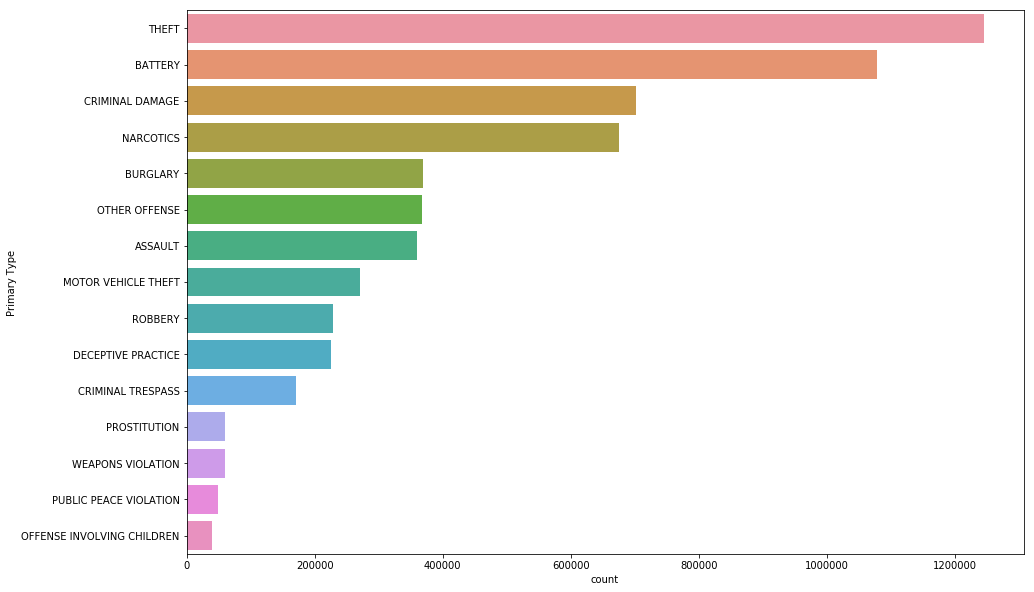

In [17]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Primary Type', data = chicago_df, order = chicago_df['Primary Type'].value_counts().iloc[:15].index)

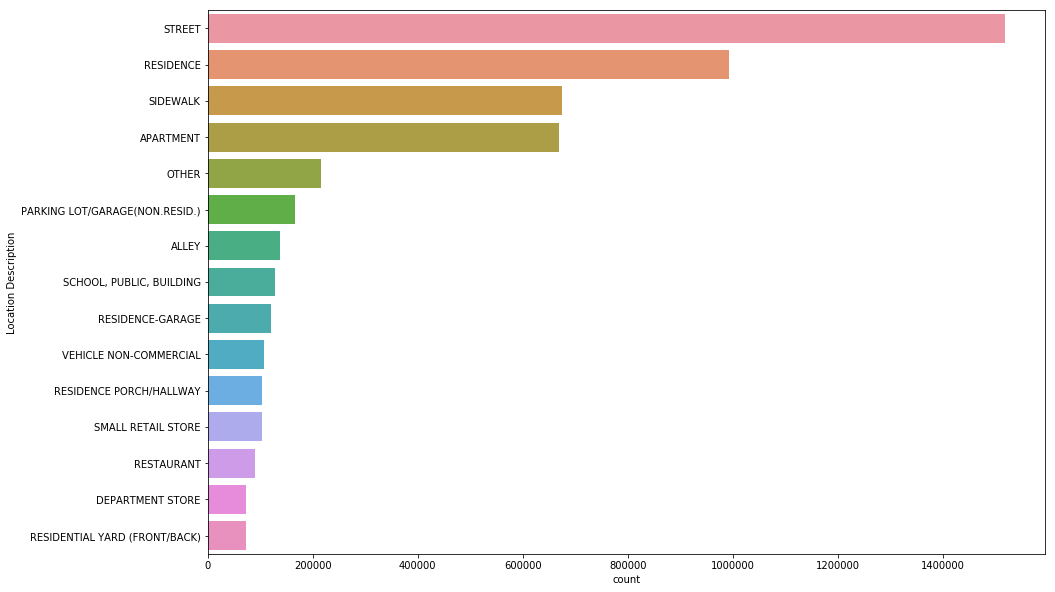

In [18]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location Description', data = chicago_df, order = chicago_df['Location Description'].value_counts().iloc[:15].index)

In [19]:
chicago_df.resample('Y').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

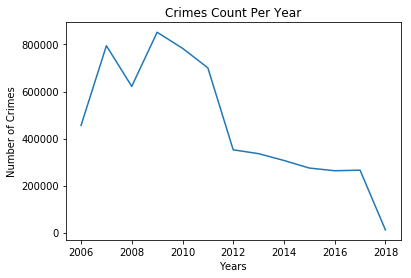

In [20]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(chicago_df.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

In [21]:
chicago_df.resample('M').size()

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
2005-06-30    40234
2005-07-31    41976
2005-08-31    41741
2005-09-30    39833
2005-10-31    40204
2005-11-30    36244
2005-12-31    33049
2006-01-31    37605
2006-02-28    34063
2006-03-31    43721
2006-04-30    69128
2006-05-31    79013
2006-06-30    77348
2006-07-31    82750
2006-08-31    80628
2006-09-30    75045
2006-10-31    76870
2006-11-30    70710
2006-12-31    67803
2007-01-31    67123
2007-02-28    53811
2007-03-31    71857
2007-04-30    70389
2007-05-31    78170
2007-06-30    55802
              ...  
2014-08-31    25802
2014-09-30    23811
2014-10-31    23911
2014-11-30    20680
2014-12-31    20891
2015-01-31    20656
2015-02-28    16287
2015-03-31    21560
2015-04-30    21610
2015-05-31    23570
2015-06-30    23059
2015-07-31    24101
2015-08-31    24685
2015-09-30    22996
2015-10-31    22979
2015-11-30    20486
2015-12-31    21006
2016-01-31    20375
2016-02-29    1

Text(0, 0.5, 'Number of Crimes')

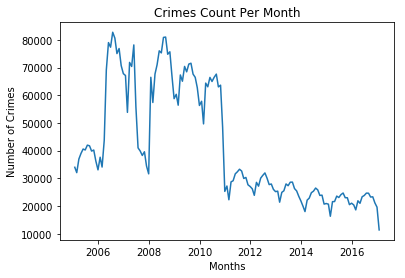

In [22]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(chicago_df.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

In [23]:
chicago_df.resample('Q').size()

Date
2005-03-31    102995
2005-06-30    119769
2005-09-30    123550
2005-12-31    109497
2006-03-31    115389
2006-06-30    225489
2006-09-30    238423
2006-12-31    215383
2007-03-31    192791
2007-06-30    204361
2007-09-30    119086
2007-12-31    105610
2008-03-31    191523
2008-06-30    222331
2008-09-30    236695
2008-12-31    201504
2009-03-31    184055
2009-06-30    203916
2009-09-30    210446
2009-12-31    185483
2010-03-31    171848
2010-06-30    194453
2010-09-30    197116
2010-12-31    137274
2011-03-31     78167
2011-06-30     93064
2011-09-30     95835
2011-12-31     85000
2012-03-31     78574
2012-06-30     88283
2012-09-30     89685
2012-12-31     79128
2013-03-31     71651
2013-06-30     80776
2013-09-30     83510
2013-12-31     70766
2014-03-31     59964
2014-06-30     72991
2014-09-30     76090
2014-12-31     65482
2015-03-31     58503
2015-06-30     68239
2015-09-30     71782
2015-12-31     64471
2016-03-31     60843
2016-06-30     68085
2016-09-30     72500
2016-12-

Text(0, 0.5, 'Number of Crimes')

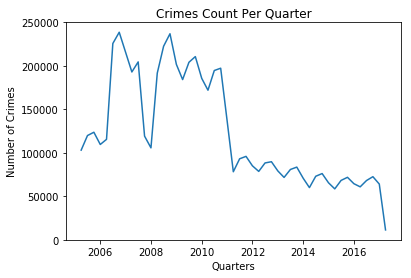

In [24]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(chicago_df.resample('Q').size())
plt.title('Crimes Count Per Quarter')
plt.xlabel('Quarters')
plt.ylabel('Number of Crimes')

# STEP #3: PREPARING THE DATA

In [0]:
chicago_prophet = chicago_df.resample('M').size().reset_index()

In [26]:
chicago_prophet

Date      0
0   2005-01-31  33983
1   2005-02-28  32042
2   2005-03-31  36970
3   2005-04-30  38963
4   2005-05-31  40572
5   2005-06-30  40234
6   2005-07-31  41976
7   2005-08-31  41741
8   2005-09-30  39833
9   2005-10-31  40204
10  2005-11-30  36244
11  2005-12-31  33049
12  2006-01-31  37605
13  2006-02-28  34063
14  2006-03-31  43721
15  2006-04-30  69128
16  2006-05-31  79013
17  2006-06-30  77348
18  2006-07-31  82750
19  2006-08-31  80628
20  2006-09-30  75045
21  2006-10-31  76870
22  2006-11-30  70710
23  2006-12-31  67803
24  2007-01-31  67123
25  2007-02-28  53811
26  2007-03-31  71857
27  2007-04-30  70389
28  2007-05-31  78170
29  2007-06-30  55802
..         ...    ...
115 2014-08-31  25802
116 2014-09-30  23811
117 2014-10-31  23911
118 2014-11-30  20680
119 2014-12-31  20891
120 2015-01-31  20656
121 2015-02-28  16287
122 2015-03-31  21560
123 2015-04-30  21610
124 2015-05-31  23570
125 2015-06-30  23059
126 2015-07-31  24101
127 2015-08-31  24685
128 2015-09-30  22996
129 2015-10-31  22979
130 2015-11-30  20486
131 2015-12-31  21006
132 2016-01-31  20375
133 2016-02-29  18590
134 2016-03-31  21878
135 2016-04-30  20962
136 2016-05-31  23332
137 2016-06-30  23791
138 2016-07-31  24646
139 2016-08-31  24619
140 2016-09-30  23235
141 2016-10-31  23314
142 2016-11-30  21140
143 2016-12-31  19580
144 2017-01-31  11357

[145 rows x 2 columns]

In [0]:
chicago_prophet.columns = ['Date', 'Crime Count']

In [28]:
chicago_prophet

Date  Crime Count
0   2005-01-31        33983
1   2005-02-28        32042
2   2005-03-31        36970
3   2005-04-30        38963
4   2005-05-31        40572
5   2005-06-30        40234
6   2005-07-31        41976
7   2005-08-31        41741
8   2005-09-30        39833
9   2005-10-31        40204
10  2005-11-30        36244
11  2005-12-31        33049
12  2006-01-31        37605
13  2006-02-28        34063
14  2006-03-31        43721
15  2006-04-30        69128
16  2006-05-31        79013
17  2006-06-30        77348
18  2006-07-31        82750
19  2006-08-31        80628
20  2006-09-30        75045
21  2006-10-31        76870
22  2006-11-30        70710
23  2006-12-31        67803
24  2007-01-31        67123
25  2007-02-28        53811
26  2007-03-31        71857
27  2007-04-30        70389
28  2007-05-31        78170
29  2007-06-30        55802
..         ...          ...
115 2014-08-31        25802
116 2014-09-30        23811
117 2014-10-31        23911
118 2014-11-30        20680
119 2014-12-31        20891
120 2015-01-31        20656
121 2015-02-28        16287
122 2015-03-31        21560
123 2015-04-30        21610
124 2015-05-31        23570
125 2015-06-30        23059
126 2015-07-31        24101
127 2015-08-31        24685
128 2015-09-30        22996
129 2015-10-31        22979
130 2015-11-30        20486
131 2015-12-31        21006
132 2016-01-31        20375
133 2016-02-29        18590
134 2016-03-31        21878
135 2016-04-30        20962
136 2016-05-31        23332
137 2016-06-30        23791
138 2016-07-31        24646
139 2016-08-31        24619
140 2016-09-30        23235
141 2016-10-31        23314
142 2016-11-30        21140
143 2016-12-31        19580
144 2017-01-31        11357

[145 rows x 2 columns]

In [0]:
chicago_prophet_df = pd.DataFrame(chicago_prophet)

In [30]:
chicago_prophet_df

Date  Crime Count
0   2005-01-31        33983
1   2005-02-28        32042
2   2005-03-31        36970
3   2005-04-30        38963
4   2005-05-31        40572
5   2005-06-30        40234
6   2005-07-31        41976
7   2005-08-31        41741
8   2005-09-30        39833
9   2005-10-31        40204
10  2005-11-30        36244
11  2005-12-31        33049
12  2006-01-31        37605
13  2006-02-28        34063
14  2006-03-31        43721
15  2006-04-30        69128
16  2006-05-31        79013
17  2006-06-30        77348
18  2006-07-31        82750
19  2006-08-31        80628
20  2006-09-30        75045
21  2006-10-31        76870
22  2006-11-30        70710
23  2006-12-31        67803
24  2007-01-31        67123
25  2007-02-28        53811
26  2007-03-31        71857
27  2007-04-30        70389
28  2007-05-31        78170
29  2007-06-30        55802
..         ...          ...
115 2014-08-31        25802
116 2014-09-30        23811
117 2014-10-31        23911
118 2014-11-30        20680
119 2014-12-31        20891
120 2015-01-31        20656
121 2015-02-28        16287
122 2015-03-31        21560
123 2015-04-30        21610
124 2015-05-31        23570
125 2015-06-30        23059
126 2015-07-31        24101
127 2015-08-31        24685
128 2015-09-30        22996
129 2015-10-31        22979
130 2015-11-30        20486
131 2015-12-31        21006
132 2016-01-31        20375
133 2016-02-29        18590
134 2016-03-31        21878
135 2016-04-30        20962
136 2016-05-31        23332
137 2016-06-30        23791
138 2016-07-31        24646
139 2016-08-31        24619
140 2016-09-30        23235
141 2016-10-31        23314
142 2016-11-30        21140
143 2016-12-31        19580
144 2017-01-31        11357

[145 rows x 2 columns]

# STEP #4: MAKE PREDICTIONS

In [31]:
chicago_prophet_df.columns

Index(['Date', 'Crime Count'], dtype='object')

In [0]:
chicago_prophet_df_final = chicago_prophet_df.rename(columns={'Date':'ds', 'Crime Count':'y'})


In [33]:
chicago_prophet_df_final

ds      y
0   2005-01-31  33983
1   2005-02-28  32042
2   2005-03-31  36970
3   2005-04-30  38963
4   2005-05-31  40572
5   2005-06-30  40234
6   2005-07-31  41976
7   2005-08-31  41741
8   2005-09-30  39833
9   2005-10-31  40204
10  2005-11-30  36244
11  2005-12-31  33049
12  2006-01-31  37605
13  2006-02-28  34063
14  2006-03-31  43721
15  2006-04-30  69128
16  2006-05-31  79013
17  2006-06-30  77348
18  2006-07-31  82750
19  2006-08-31  80628
20  2006-09-30  75045
21  2006-10-31  76870
22  2006-11-30  70710
23  2006-12-31  67803
24  2007-01-31  67123
25  2007-02-28  53811
26  2007-03-31  71857
27  2007-04-30  70389
28  2007-05-31  78170
29  2007-06-30  55802
..         ...    ...
115 2014-08-31  25802
116 2014-09-30  23811
117 2014-10-31  23911
118 2014-11-30  20680
119 2014-12-31  20891
120 2015-01-31  20656
121 2015-02-28  16287
122 2015-03-31  21560
123 2015-04-30  21610
124 2015-05-31  23570
125 2015-06-30  23059
126 2015-07-31  24101
127 2015-08-31  24685
128 2015-09-30  22996
129 2015-10-31  22979
130 2015-11-30  20486
131 2015-12-31  21006
132 2016-01-31  20375
133 2016-02-29  18590
134 2016-03-31  21878
135 2016-04-30  20962
136 2016-05-31  23332
137 2016-06-30  23791
138 2016-07-31  24646
139 2016-08-31  24619
140 2016-09-30  23235
141 2016-10-31  23314
142 2016-11-30  21140
143 2016-12-31  19580
144 2017-01-31  11357

[145 rows x 2 columns]

In [34]:
m = Prophet()
m.fit(chicago_prophet_df_final)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [36]:
forecast

ds         trend  ...  multiplicative_terms_upper          yhat
0   2005-01-31  60454.736755  ...                         0.0  55692.336707
1   2005-02-28  60322.333828  ...                         0.0  50821.824937
2   2005-03-31  60175.744873  ...                         0.0  58951.596630
3   2005-04-30  60033.884593  ...                         0.0  61216.714978
4   2005-05-31  59887.295638  ...                         0.0  65385.545746
5   2005-06-30  59745.435359  ...                         0.0  63322.400224
6   2005-07-31  59598.846404  ...                         0.0  64181.693865
7   2005-08-31  59452.257449  ...                         0.0  63951.223724
8   2005-09-30  59310.397170  ...                         0.0  61059.759771
9   2005-10-31  59163.808215  ...                         0.0  61561.256094
10  2005-11-30  59021.947937  ...                         0.0  56957.253700
11  2005-12-31  58875.358983  ...                         0.0  52883.751837
12  2006-01-31  58728.770029  ...                         0.0  53956.630761
13  2006-02-28  58596.367103  ...                         0.0  49093.744195
14  2006-03-31  58449.778149  ...                         0.0  57225.488819
15  2006-04-30  58307.917865  ...                         0.0  59494.876820
16  2006-05-31  58161.328904  ...                         0.0  63612.376998
17  2006-06-30  58019.468619  ...                         0.0  61583.069992
18  2006-07-31  57872.879659  ...                         0.0  62435.613577
19  2006-08-31  57726.290697  ...                         0.0  62205.870192
20  2006-09-30  57584.430412  ...                         0.0  59414.087023
21  2006-10-31  57437.841451  ...                         0.0  59877.773362
22  2006-11-30  57295.981166  ...                         0.0  55250.954259
23  2006-12-31  57149.392204  ...                         0.0  51136.481568
24  2007-01-31  56994.694150  ...                         0.0  52212.200708
25  2007-02-28  56854.966876  ...                         0.0  47353.461739
26  2007-03-31  56700.268822  ...                         0.0  55475.143238
27  2007-04-30  56550.561028  ...                         0.0  57740.646991
28  2007-05-31  56395.862975  ...                         0.0  61797.709995
29  2007-06-30  56230.827264  ...                         0.0  59781.747812
..         ...           ...  ...                         ...           ...
480 2018-01-02  10430.708594  ...                         0.0   4616.671246
481 2018-01-03  10417.641911  ...                         0.0   4692.439644
482 2018-01-04  10404.575228  ...                         0.0   4764.747009
483 2018-01-05  10391.508545  ...                         0.0   4831.395464
484 2018-01-06  10378.441862  ...                         0.0   4890.596606
485 2018-01-07  10365.375179  ...                         0.0   4941.013308
486 2018-01-08  10352.308495  ...                         0.0   4981.785076
487 2018-01-09  10339.241812  ...                         0.0   5012.536264
488 2018-01-10  10326.175129  ...                         0.0   5033.366987
489 2018-01-11  10313.108446  ...                         0.0   5044.827160
490 2018-01-12  10300.041763  ...                         0.0   5047.874613
491 2018-01-13  10286.975080  ...                         0.0   5043.818762
492 2018-01-14  10273.908397  ...                         0.0   5034.251801
493 2018-01-15  10260.841714  ...                         0.0   5020.969766
494 2018-01-16  10247.775030  ...                         0.0   5005.886170
495 2018-01-17  10234.708347  ...                         0.0   4990.941175
496 2018-01-18  10221.641664  ...                         0.0   4978.009409
497 2018-01-19  10208.574981  ...                         0.0   4968.809591
498 2018-01-20  10195.508298  ...                         0.0   4964.819125
499 2018-01-21  10182.441615  ...                         0.0   4967.196641
500 2018-01-22  10169.374932  ...                         0.

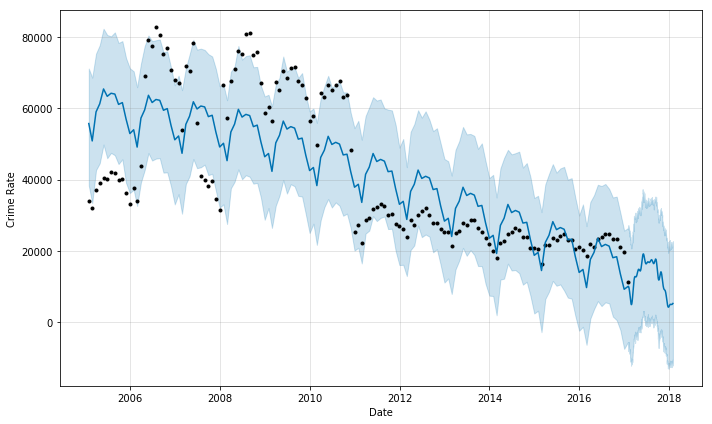

In [37]:
figure = m.plot(forecast, xlabel='Date', ylabel='Crime Rate')

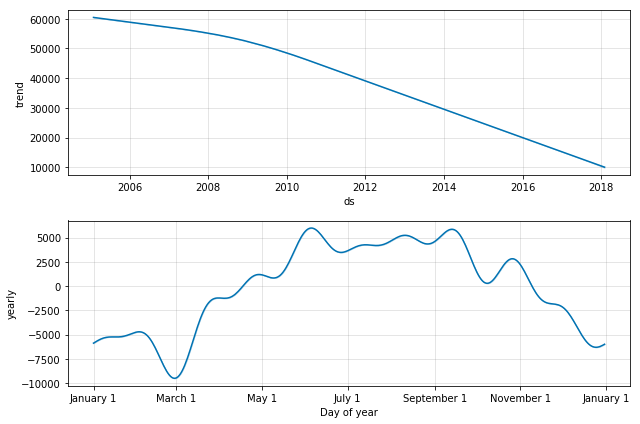

In [38]:
figure3 = m.plot_components(forecast)